In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import bliss

from bliss.datasets.simulated import SimulatedDataset
import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
# torch.manual_seed(2342)
# np.random.seed(354)

# Model parameters

In [4]:
# create training dataset
n_bands = 2
slen = 8

tile_slen = 2

In [5]:
# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)

In [7]:
# None referes to no galaxies
prob_galaxy = 0.
dec_args = (None, psf_params, background)

decoder_kwargs = dict(n_bands=n_bands,
                        slen=slen,
                        tile_slen=tile_slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=4,
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=True)

# Define dataset

In [8]:
batchsize = 2
dataset = SimulatedDataset(20, batchsize, dec_args, decoder_kwargs)

### Draw latent variables and image

In [9]:
batch_params = dataset.get_batch()

In [10]:
n_sources_full, locs_full, galaxy_params_full, fluxes_full = \
    encoder_lib._get_full_params_from_sampled_params(
                                                    slen,
                                                    tile_slen,
                                                    batch_params['n_sources'],
                                                    batch_params['locs'], 
                                                    batch_params['galaxy_params'], 
                                                    batch_params['fluxes'])

In [11]:
%matplotlib inline  

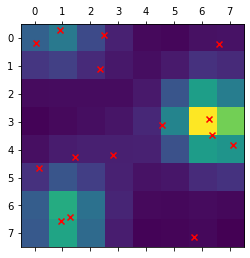

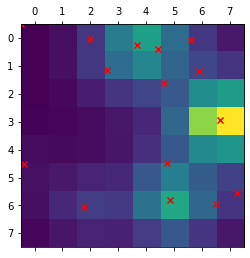

In [12]:
for batch in range(batchsize): 
    plt.matshow(batch_params['images'][batch, 0].detach().cpu())
    plt.scatter(locs_full[batch, :, 1].cpu() * slen - 0.5, 
                  locs_full[batch, :, 0].cpu() * slen - 0.5, 
                  color = 'red', marker = 'x')


# Define encoder and get tiles

In [13]:
edge_padding = 3
ptile_slen = tile_slen + 2 * edge_padding
encoder = encoder_lib.ImageEncoder(slen=slen,
                        ptile_slen=ptile_slen,
                        tile_slen=tile_slen,
                        n_bands=n_bands,
                        max_detections=dataset.image_decoder.max_sources_per_tile,
                        n_galaxy_params=8,
                        enc_conv_c=20,
                        enc_kern=3,
                        enc_hidden=256,
                        momentum=0.5)

# Plot the image tiles

In [14]:
image_tiles = encoder.get_images_in_tiles(batch_params['images'])

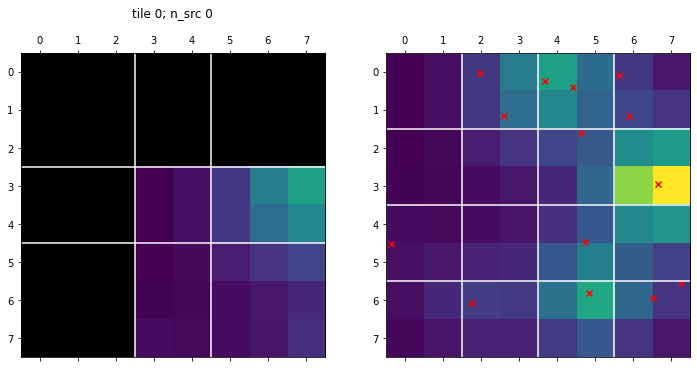

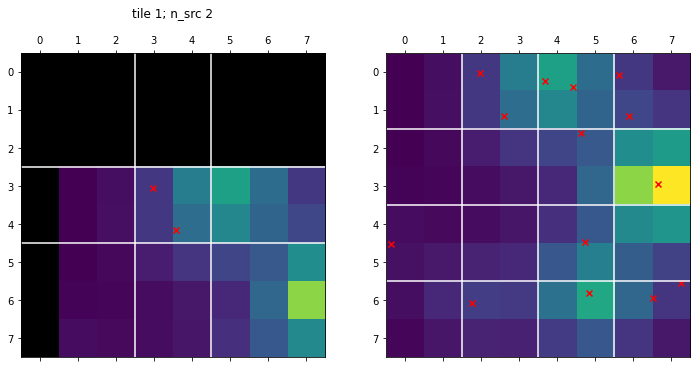

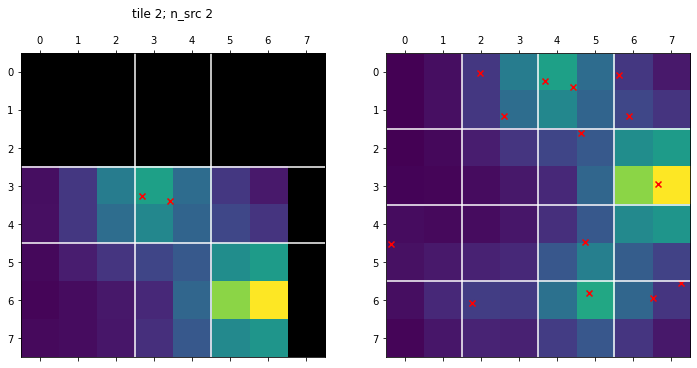

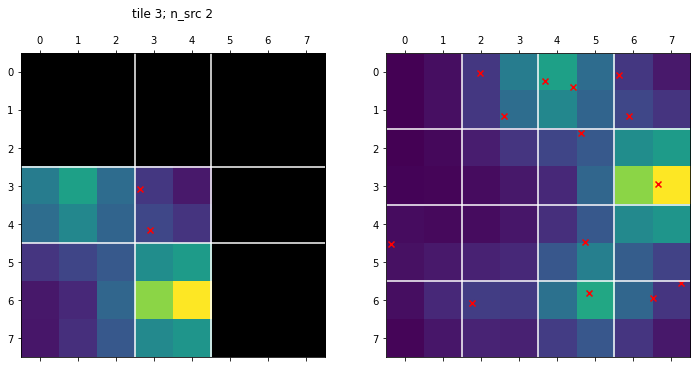

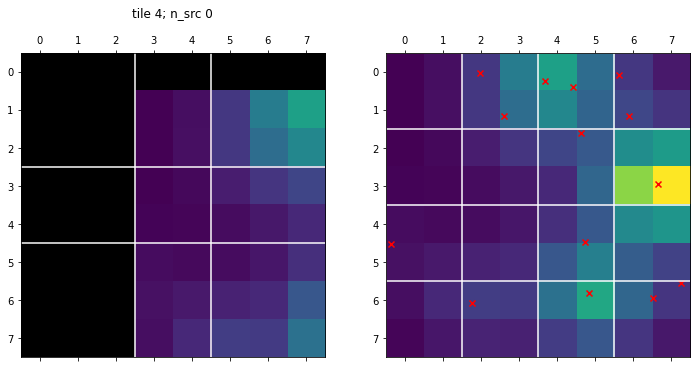

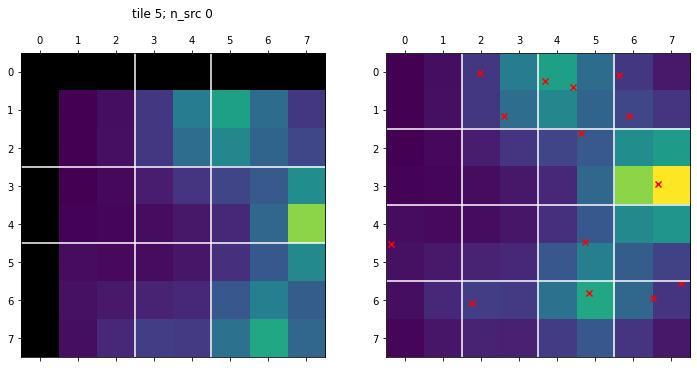

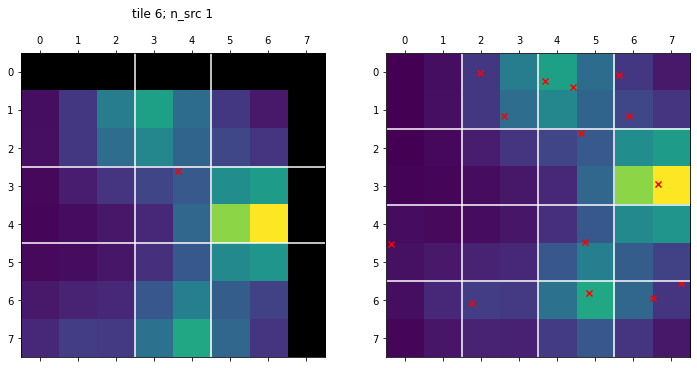

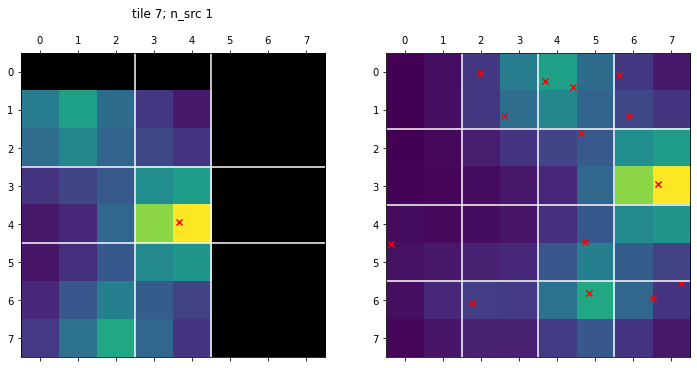

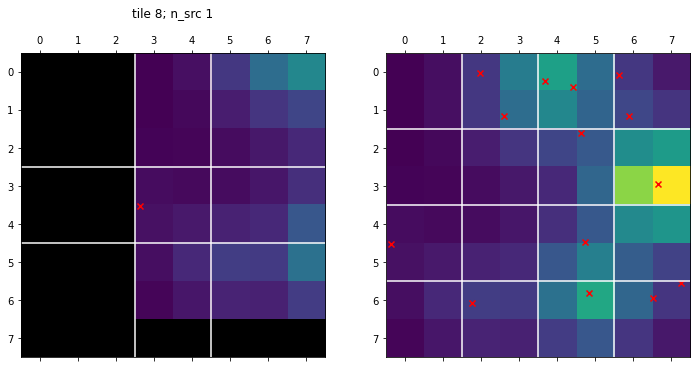

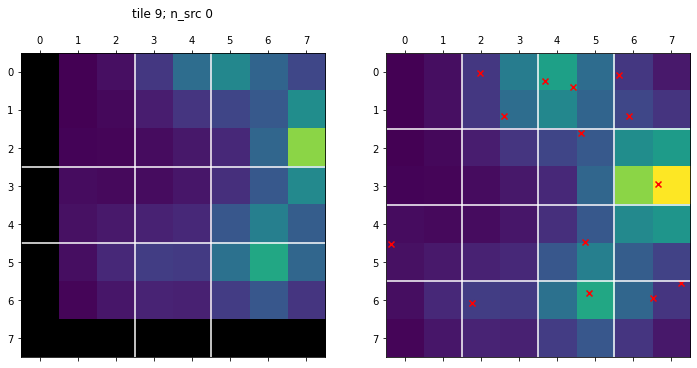

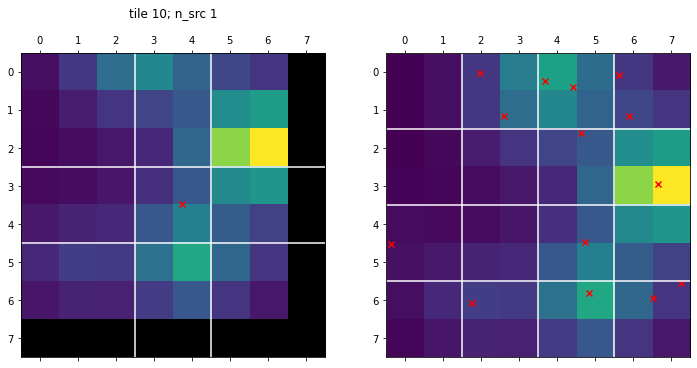

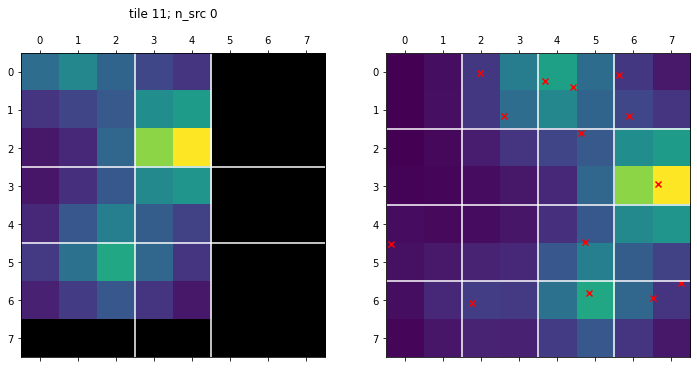

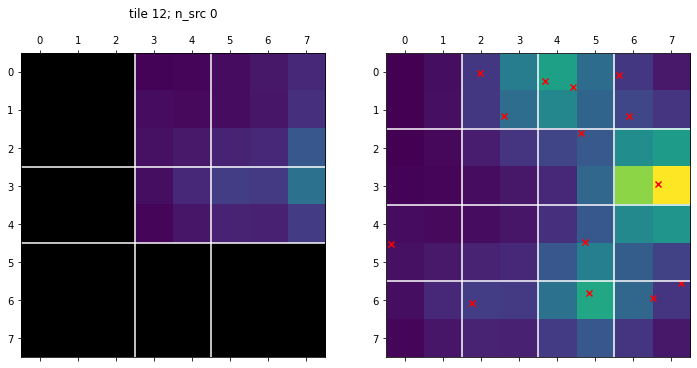

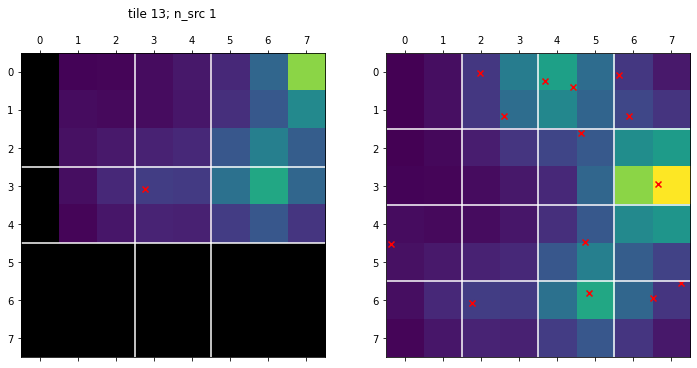

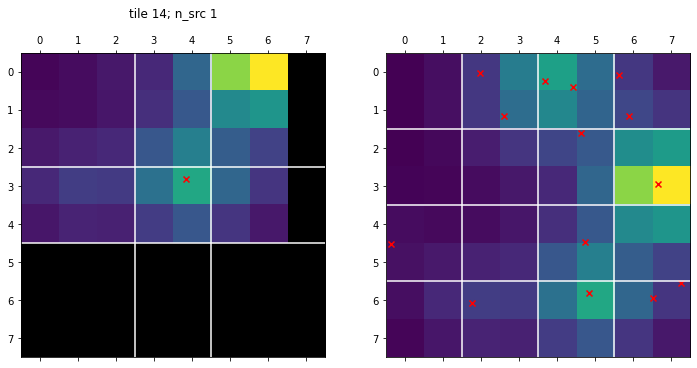

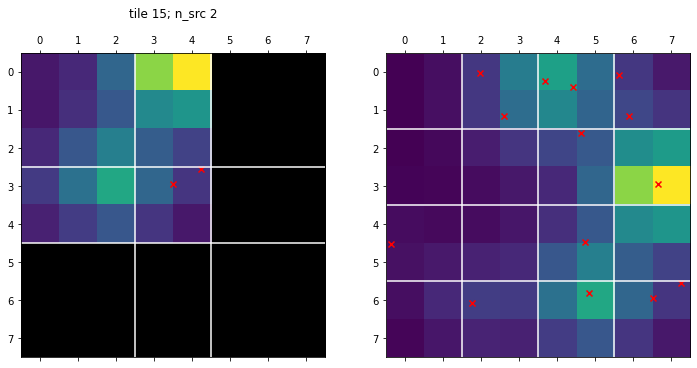

In [15]:
for i in range(encoder.n_tiles_per_image): 
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    #####################
    # plot full image
    #####################
    # get full image
    image = batch_params['images'][batch, 0].cpu().detach()

    ax[1].matshow(image)
    for k in range(int(slen / tile_slen)): 
        ax[1].axvline(tile_slen * k - 0.5, color = 'white')
        ax[1].axhline(tile_slen * k - 0.5, color = 'white')
    
    
    # plot stars on full image
    n = int(n_sources_full[batch])
    ax[1].scatter(locs_full[batch, 0:n, 1].cpu() * slen - 0.5, 
                  locs_full[batch, 0:n, 0].cpu() * slen - 0.5, 
                  color = 'red', marker = 'x')

    #####################
    # plot image tile
    #####################
    # for plotting only: 
    # this sets the padding to be black
    cmap = plt.cm.viridis
    cmap.set_under(color='black')    
    image_tiles[image_tiles == encoder.background_pad_value] = image.min() - 1.


    n_src = int(batch_params['n_sources'][batch][i].cpu().numpy())
    tile_indx = i + batch * encoder.n_tiles_per_image
    ax[0].matshow(image_tiles[tile_indx, 0].detach().cpu(), vmax = image.max() + 1e-2, vmin = image.min() - 1e-2)
    ax[0].set_title('tile ' + str(i) + 
                    '; n_src ' + str(n_src) + '\n')
    
    # plot stars on image tile
    which_star = (batch_params['galaxy_bool'][batch, i] == 0).squeeze().cpu() & \
                    (torch.arange(encoder.max_detections) < n_src).bool()
    locs = batch_params['locs'][batch, i, which_star].cpu()
    locs = locs * tile_slen + edge_padding - 0.5
    ax[0].scatter(locs[:, 1], locs[:, 0], 
                  color = 'red', marker = 'x')
    ax[0].axvline(edge_padding - 0.5, color = 'white')
    ax[0].axvline(tile_slen + edge_padding - 0.5, color = 'white')
    ax[0].axhline(edge_padding - 0.5, color = 'white')
    ax[0].axhline(tile_slen + edge_padding - 0.5, color = 'white')
    
